<a href="https://colab.research.google.com/github/toyo97/rgbd-domain-adaptation/blob/master/RGB_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GABRIELE

**Reading data**

In [0]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
from torchvision.datasets import VisionDataset

from PIL import Image

import os
import os.path
import sys


def pil_loader(path):

    with open(path, 'rb') as f:

        img = Image.open(f)
        return img.convert('RGB')


class ROD(VisionDataset):
  
    def __init__(self, root, split='real', transform=None, target_transform=None):
        super(ROD, self).__init__(root, transform=transform, target_transform=target_transform)


        if split not in ['real','synthetic']:
          raise ValueError("Split not acceptable")

        self.split = split
        self.images=[]
        self.categories={}

        numCat = 0

        with open(os.path.join(self.root.split("/")[0], self.split + ".txt")) as f:
          for line in f.read().splitlines():
            category = line.split("/")[0]
            if category=="BACKGROUND_Google":
              continue
            if category in self.categories:
              label = self.categories[category]
            else:
              self.categories[category] = numCat
              label = numCat
              numCat = numCat+1
            self.images.append(((pil_loader(os.path.join(self.root,line))), label))
          

    def __getitem__(self, index):

        image, label = self.images[index] 

        if self.transform is not None:

            image = self.transform(image)

        return image, label

    def __len__(self):

        length = len(self.images) 

        return length

In [0]:
A = 5
print( A)

5


#VITTORIO

In [0]:
!find "/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/" -iname *56_crop.png | head -5

/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/rubber_eraser/rubber_eraser_3/rubber_eraser_3_4_256_crop.png
/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/rubber_eraser/rubber_eraser_3/rubber_eraser_3_4_56_crop.png
/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/toothbrush/toothbrush_1/toothbrush_1_2_156_crop.png
/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/toothbrush/toothbrush_1/toothbrush_1_1_156_crop.png
/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/toothbrush/toothbrush_1/toothbrush_1_1_56_crop.png


## Rotation transformation

Source: https://pytorch.org/docs/stable/torchvision/transforms.html

In [0]:
import torchvision.transforms.functional as TF
import random
import numpy as np


def coupled_rotation(image_tuple, label):

  def one_hot(n):
    oen = np.zeros(4)
    oen[n] = 1
    return oen

  j = random.randint(0,3)
  k = random.randint(0,3)

  z = one_hot((k-j) % 4)

  # Note: TF.rotate is counter-clockwise
  rotated_image_tuple = TF.rotate(image_tuple[0], 270*j), TF.rotate(image_tuple[1], 270*k)

  return rotated_image_tuple, z

**TEST**

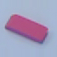

In [0]:
img_path_a = '/content/drive/.shortcut-targets-by-id/16wqOZSiZTtePcpIKmKI-vbC315ABUVuk/RGB Project/ROD/ROD_rgb/rubber_eraser/rubber_eraser_3/rubber_eraser_3_4_56_crop.png'
a = Image.open(img_path_a).convert('RGB')

display(a)

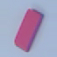

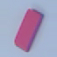

"How many times should the first image be rotated by 90 degrees clockwise to align with the second?"
0 time(s), i.e. relative rotation of 0 degrees, one hot encoded [1. 0. 0. 0.]


In [0]:
from IPython.display import display # to display images

rit, z = coupled_rotation((a,a), 'label')
display(rit[0])
display(rit[1])
print('"How many times should the first image be rotated by 90 degrees clockwise to align with the second?"')
print(f'{np.argmax(z)} time(s), i.e. relative rotation of {np.argmax(z) * 90} degrees, one hot encoded {z}')

#EMANUELE

In [0]:
from torchvision import models
import torch
import torch.nn as nn

In [0]:
class MyModel (nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.resnet18 = models.resnet18(pretrained=True)
    self.depthFeatureExtractor = nn.Sequential(*(list(self.resnet18.children())[:-2])) # Eliminate last fc and avg pool
    self.rgbFeatureExtractor = nn.Sequential(*(list(self.resnet18.children())[:-2])) # Eliminate last fc and avg pool
    
    self.mainHead = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), # output has shape (batch_size, num_featues, 1, 1)
        nn.Linear(512 , 1000),        # wants first dimension = batch_size
                                      # In resnet18 it is 512 * block.expansion -> ???
        nn.BatchNorm1d(num_features=1000),
        nn.Relu(),
        nn.Linear(1000, NUM_CLASSES),
        nn.Softmax()
    )

    self.pretextHead = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=100, kernel_size=(1,1), bias=True), # output img = 100 channels of 7x7
        nn.BatchNorm2d(num_features=100),
        nn.Relu(),
        nn.Conv2d(in_channels=100, out_channels=100, kernel_size=(3,3), bias=True), # output img = 100 channels of 98x98
        nn.BatchNorm2d(num_features=100),
        nn.Relu(),
        nn.Linear(100*98*98, 100),
        nn.BatchNorm1d(num_features=100),
        nn.Relu(),
        nn.Linear(100, 4),
        nn.Softmax()
    )


  def forward(self, x, task): # x is the batch
    self.rgbFeatures = self.rgbFeatureExtractor(x) # list of rgb filters of the batch (list_size = batch_size)
    self.depthFeatures = self.depthFeatureExtractor(x) 
    self.allFeatures=torch.cat((self.depthFeatures, self.rgbFeatures),1) # To check: concatenate along right direction? 
                                                          # size_allFeatures = (batch_size, number_filters, height, width)
                                                          # number_filters = 512
                                                          # height = width = 7 if input of network is 224x224
    if (task == 'head'): # S in the paper
      out1 = self.mainHead[0](allFeatures)
      out1 = torch.flatten(out1, 1)  # size = batch_size, num_features*h*w 
      out1 = self.mainHead[1](out1)
      out1 = self.mainHead[2](out1)
      out1 = self.mainHead[3](out1)
      out1 = self.mainHead[4](out1)
      class_scores = self.mainHead[5](out1) # class scores of the batch
      return class_scores

    else: # Stilda, Tdilda, T in the paper
      out2 = self.pretextHead[0](allFeatures)
      out2 = self.pretextHead[1](out2)
      out2 = self.pretextHead[2](out2)
      out2 = self.pretextHead[3](out2)
      out2 = self.pretextHead[4](out2)
      out2 = self.pretextHead[5](out2)
      out2 = torch.flatten(out2, 1)
      out2 = self.pretextHead[6](out2)
      out2 = self.pretextHead[7](out2)
      out2 = self.pretextHead[8](out2)
      out2 = self.pretextHead[9](out2)
      rotation_scores = self.pretextHead[10](out2)
      return rotation_scores